# Example of messing around with correlating the data



In [1]:
#Magic function to enable interactive plotting in Jupyter notebook
#Allows you to zoom/pan within plots after generating
#Normally, this would be %matplotlib notebook, but since we're using Juptyerlab, we need a different widget
#%matplotlib notebook
%matplotlib inline

In [59]:
import warnings
warnings.filterwarnings('ignore')
#Import necesary modules
#Use shorter names (np, pd, plt) instead of full (numpy, pandas, matplotlib.pylot) for convenience
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import numpy.ma as ma
import h5py
import s3fs
import matplotlib.pyplot as plt
import netCDF4
import xarray as xr
import os
import readintoxr

# Use seasborn for nicer looking inline plots if available 
#import seaborn as sns
#sns.set(context='notebook', style='darkgrid')
#st = axes_style("whitegrid")


#### Beam selection   
There are 6 beams to choose from in the ICESat-2 products (3 pairs of a strong and weak beam). The energy ratio between the weak and strong beams are  approximately 1:4 and are separated by 90 m in the across-track direction. The beam pairs are separated by ~3.3 km in the across-track direction, and the strong and weak beams are separated by ~2.5 km in the along-track direction.

#### chose a file to read



In [3]:
ATL07file='processed_ATL07-01_20181130235806_09680101_001_01.h5'
ATL07file='processed_ATL07-01_20181206115828_10520101_001_01.h5'
localFilePath='/home/jovyan/DATA/'+ATL07file
fig_dir = '/home/jovyan/figures/'


In [60]:
ds1r = MakeDataSet(localFilePath, beam = 'gt1r')
ds1l = MakeDataSet(localFilePath, beam = 'gt1l')



Take a look at the dataset we made 

<xarray.Dataset>
Dimensions:       (segs: 346966)
Coordinates:
    lon           (segs) float64 -0.5842 -0.5842 -0.5842 ... -165.2 -165.2
    lat           (segs) float64 79.83 79.83 79.83 79.83 ... 71.08 71.08 71.08
    time          (segs) datetime64[ns] 2018-12-06T11:57:46 ... 2018-12-06T12:05:20
    delta_time    (segs) float64 2.933e+07 2.933e+07 ... 2.933e+07 2.933e+07
    lon360        (segs) float64 359.4 359.4 359.4 359.4 ... 194.8 194.8 194.8
  * segs          (segs) int64 0 1 2 3 4 ... 346961 346962 346963 346964 346965
Data variables:
    seg_dist      (segs) float64 8.92e+06 8.92e+06 ... 1.214e+07 1.214e+07
    height        (segs) float32 3.4028235e+38 3.4028235e+38 ... 0.20854685
    mss           (segs) float32 35.521385 35.521385 ... 0.009609258 0.009584308
    seg_length    (segs) float32 8106.915 4052.4314 ... 24.175938 46.304184
    quality_flag  (segs) int8 -1 -1 -1 -1 -1 -1 -1 -1 -1 ... 1 1 1 1 1 1 1 1 1
    isita_lead    (se

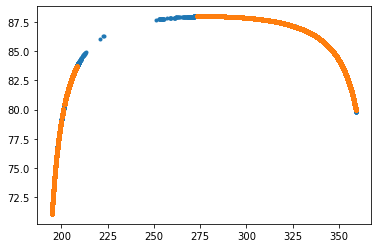

In [61]:
plt.plot(ds1r.lon360,ds1r.lat,'.',ds1l.lon360,ds1l.lat,'.')

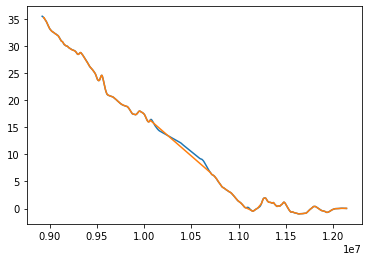

In [62]:
plt.plot(ds1r.seg_dist,ds1r.mss,ds1l.seg_dist,ds1l.mss)

In [63]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def _check_arg(x, xname):
    x = np.asarray(x)
    if x.ndim != 1:
        raise ValueError('%s must be one-dimensional.' % xname)
    return x

def autocorrelation(x, maxlag):
    """
    Autocorrelation with a maximum number of lags.

    `x` must be a one-dimensional numpy array.

    This computes the same result as
        numpy.correlate(x, x, mode='full')[len(x)-1:len(x)+maxlag]

    The return value has length maxlag + 1.
    """
    x = _check_arg(x, 'x')
    p = np.pad(x.conj(), maxlag, mode='constant')
    T = as_strided(p[maxlag:], shape=(maxlag+1, len(x) + maxlag),
                   strides=(-p.strides[0], p.strides[0]))
    return T.dot(p[maxlag:].conj())


def crosscorrelation(x, y, maxlag):
    """
    Cross correlation with a maximum number of lags.

    `x` and `y` must be one-dimensional numpy arrays with the same length.

    This computes the same result as
        numpy.correlate(x, y, mode='full')[len(a)-maxlag-1:len(a)+maxlag]

    The return vaue has length 2*maxlag + 1.
    """
    x = _check_arg(x, 'x')
    y = _check_arg(y, 'y')
    py = np.pad(y.conj(), 2*maxlag, mode='constant')
    T = as_strided(py[2*maxlag:], shape=(2*maxlag+1, len(y) + 2*maxlag),
                   strides=(-py.strides[0], py.strides[0]))
    px = np.pad(x, maxlag, mode='constant')
    return T.dot(px)


(0.0, 20.0)

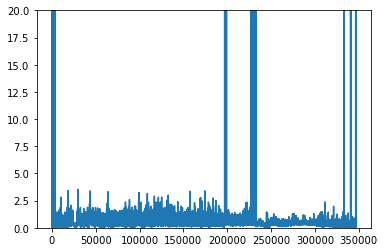

In [64]:
plt.plot(ds1r.height) # oh there are clearly bad values
plt.ylim([0.,20.])

<xarray.DataArray 'height' (segs: 346966)>
array([     nan,      nan,      nan, ..., 0.133968, 0.131038, 0.208547],
      dtype=float32)
Coordinates:
    lon         (segs) float64 -0.5842 -0.5842 -0.5842 ... -165.2 -165.2 -165.2
    lat         (segs) float64 79.83 79.83 79.83 79.83 ... 71.08 71.08 71.08
    time        (segs) datetime64[ns] 2018-12-06T11:57:46 ... 2018-12-06T12:05:20
    delta_time  (segs) float64 2.933e+07 2.933e+07 ... 2.933e+07 2.933e+07
    lon360      (segs) float64 359.4 359.4 359.4 359.4 ... 194.8 194.8 194.8
  * segs        (segs) int64 0 1 2 3 4 5 ... 346961 346962 346963 346964 346965


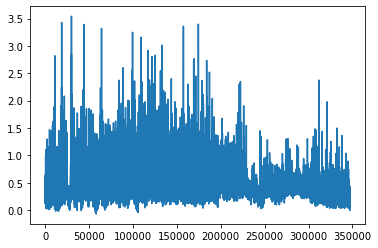

In [65]:
igood = ds1r.height.values<20.0
da_height_withnan = ds1r.height.where(igood)   # leaves nan where not true
print(da_height_withnan) # notice the segs are same total #
plt.plot(da_height_withnan)

<xarray.DataArray 'height' (segs: 345815)>
array([0.229414, 0.269694, 0.270873, ..., 0.133968, 0.131038, 0.208547],
      dtype=float32)
Coordinates:
    lon         (segs) float64 -0.739 -0.7392 -0.7397 ... -165.2 -165.2 -165.2
    lat         (segs) float64 79.96 79.96 79.96 79.96 ... 71.08 71.08 71.08
    time        (segs) datetime64[ns] 2018-12-06T11:57:48 ... 2018-12-06T12:05:20
    delta_time  (segs) float64 2.933e+07 2.933e+07 ... 2.933e+07 2.933e+07
    lon360      (segs) float64 359.3 359.3 359.3 359.3 ... 194.8 194.8 194.8
  * segs        (segs) int64 66 67 68 69 77 ... 346962 346963 346964 346965


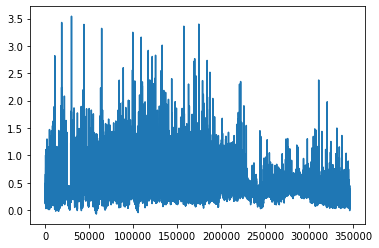

In [66]:
da_height_nonan = ds1r.height[igood]         # eliminates where not true makes dataarray
print(da_height_nonan) # notice there are fewer segs
plt.plot(da_height_nonan)

In [67]:
acorr_itall = autocorrelation(da_height_nonan , 2000)
acorrfirst2thirds = autocorrelation(da_height_nonan[0:220000] , 2000)
acorrlastthird    = autocorrelation(da_height_nonan[220000:340000] , 2000)
lags=np.arange(0,2001,1)

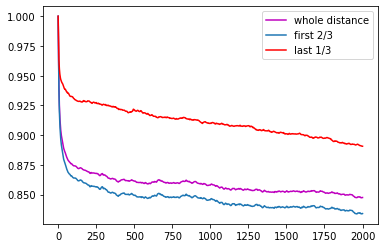

In [68]:
plt.plot(lags,acorr_itall/acorr_itall[0],'m',
         lags,acorrfirst2thirds/acorrfirst2thirds[0],
         lags,acorrlastthird/acorrlastthird[0],'r')
plt.legend(('whole distance','first 2/3','last 1/3'))

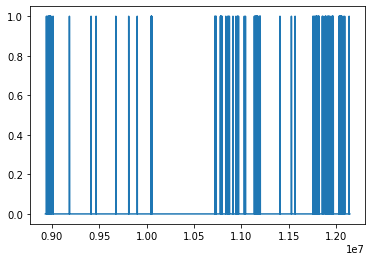

In [69]:
plt.plot(ds1r.seg_dist[igood],ds1r.isita_lead[igood])

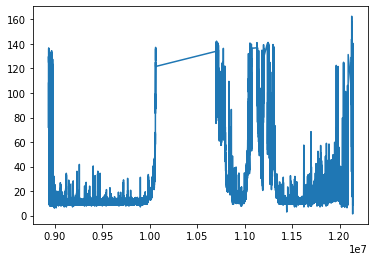

In [70]:
plt.plot(ds1r.seg_dist[igood],ds1r.seg_length[igood])

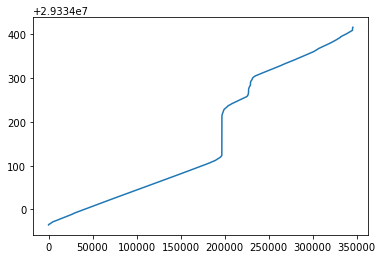

In [71]:
plt.plot(ds1r.delta_time[igood])

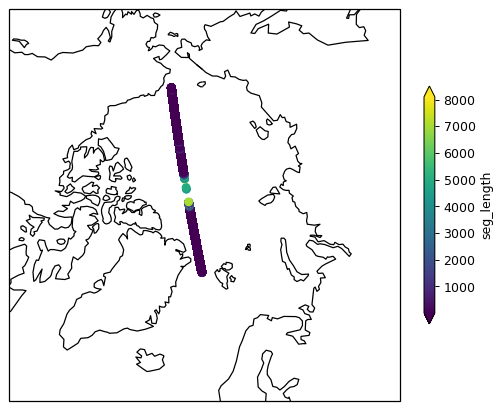

In [74]:
# Select variable of interest from the dataframe columns
# choices are 'height' or 'seg_dist' or other variables in the dataset

da_height_withnan = ds1r.height.where(ds1r.height<20)   # leaves nan where not true

plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(ds1r.lon, ds1r.lat, c=da, cmap='viridis', transform=ccrs.PlateCarree())
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=cvar, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())

/home/jovyan/figures/processed_ATL07-01_20181206115828_10520101_001_01.h5_seg_lengths.png


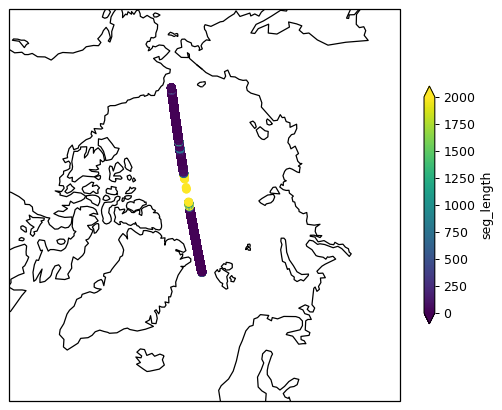

In [73]:
# Select variable of interest from the dataframe columns
# choices are 'height' or 'seg_dist'
cvar='seg_length'
da = ds1r[cvar]
plt.figure(figsize=(7,7), dpi= 90)
# Make a new projection "NorthPolarStereo"
ax = plt.axes(projection=ccrs.NorthPolarStereo(true_scale_latitude=70))
plt.scatter(ds1r.lon, ds1r.lat, c=da, cmap='viridis', transform=ccrs.PlateCarree(),vmin=0, vmax=2000)
#plt.pcolormesh(lons, lats, tile_to_plot,
#               transform=ccrs.PlateCarree());

ax.coastlines()
#ax.drawmeridians()
plt.colorbar(label=cvar, shrink=0.5, extend='both')

# Limit the map to -60 degrees latitude and below.
ax.set_extent([-180, 180, 90, 60], ccrs.PlateCarree())



f_out = os.path.join(fig_dir,ATL07file+'_seg_lengths.png')
print(f_out)
plt.savefig(f_out,bbox_inches='tight', dpi=200)
